In [82]:
!pip install tensorflowjs

In [83]:
!pip install tensorflow==2.15.0

In [84]:
!pip3 install tensorflow_decision_forests==1.8.1

In [85]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, TextVectorization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
data = pd.read_csv("/content/drive/MyDrive/Bangkit/NLP/dataset/cleaned_labeled_augmen.txt", sep=":", names=["job_title", "label"])

In [88]:
#reporsesing data
data['label'] = data['label'].str.strip()
data['job_title'] = data['job_title'].str.lower()
data['job_title'] = data['job_title'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
data['job_title'] = data['job_title'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

# menghilangkan job yang kosong
data = data[data['job_title'] != '']

# Encode label
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

# cek data
print(data.head())
print(label_encoder.classes_)


                                       job_title  label
0  segera bergabung sebagai staff dapur produksi      1
1          kami membutuhkan judi online operator      0
2                 dibuka lowongan penjaga warung      1
3                    butuh cepat ao funding dana      1
4                 dibuka lowongan jasa naik rank      1
['illegal' 'legal']


In [89]:
# Features dan labels
X = data['job_title']
y = data['label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Print sample data
print("Train samples:", len(X_train))
print("Test samples:", len(X_test))


Train samples: 3230
Test samples: 359


In [90]:
# Define TextVectorization layer
vectorize_layer = TextVectorization(
    max_tokens=1000,
    output_sequence_length=20
)

# Adapt vectorizer untuk training data
vectorize_layer.adapt(X_train)

# Vectorize  data
train_sequences = vectorize_layer(X_train)
test_sequences = vectorize_layer(X_test)

# Convert ke TensorFlow Dataset
train_dataset_vectorized = tf.data.Dataset.from_tensor_slices((train_sequences, y_train))
test_dataset_vectorized = tf.data.Dataset.from_tensor_slices((test_sequences, y_test))

# Batch dan prefetch datasets
BATCH_SIZE = 32
train_dataset = (train_dataset_vectorized.shuffle(1000)
                                        .batch(BATCH_SIZE)
                                        .prefetch(tf.data.AUTOTUNE))

test_dataset = (test_dataset_vectorized.batch(BATCH_SIZE)
                                       .prefetch(tf.data.AUTOTUNE))


In [91]:
# model
model = tf.keras.models.Sequential([
    Embedding(input_dim=1000, output_dim=128, input_length=20),
    Bidirectional(LSTM(128, dropout=0.2, return_sequences=True)),
    Bidirectional(LSTM(64, dropout=0.2)),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(1, activation='sigmoid')
])

# Membangun model untuk memastikan dimensi input yang benar
model.build(input_shape=(None, 20))


# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# menampilkan structure model
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 128)           128000    
                                                                 
 bidirectional_6 (Bidirecti  (None, 20, 256)           263168    
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 563841 (2.15 MB)
Trainable params: 56384

In [92]:
# melalakukan class weights unutk mengatasi data imbalance
class_weight = {
    0: len(y) / (2 * y.value_counts()[0]),
    1: len(y) / (2 * y.value_counts()[1])
}

# Train model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20,
    class_weight=class_weight
)


Epoch 1/20
101/101 [==============================] - 28s 177ms/step - loss: 0.9495 - accuracy: 0.8616 - val_loss: 0.8509 - val_accuracy: 0.8245
Epoch 2/20
101/101 [==============================] - 16s 159ms/step - loss: 0.2289 - accuracy: 0.9703 - val_loss: 0.2607 - val_accuracy: 0.9304
Epoch 3/20
101/101 [==============================] - 16s 158ms/step - loss: 0.1106 - accuracy: 0.9786 - val_loss: 0.3400 - val_accuracy: 0.8607
Epoch 4/20
101/101 [==============================] - 16s 160ms/step - loss: 0.0853 - accuracy: 0.9740 - val_loss: 0.1839 - val_accuracy: 0.9331
Epoch 5/20
101/101 [==============================] - 16s 162ms/step - loss: 0.0619 - accuracy: 0.9814 - val_loss: 0.3533 - val_accuracy: 0.8858
Epoch 6/20
101/101 [==============================] - 16s 162ms/step - loss: 0.0482 - accuracy: 0.9885 - val_loss: 0.2752 - val_accuracy: 0.9164
Epoch 7/20
101/101 [==============================] - 16s 158ms/step - loss: 0.0480 - accuracy: 0.9836 - val_loss: 0.2411 - val_ac

In [93]:
# Save model format h5
model.save("saved_model.h5", save_format="h5")


from tensorflow.keras.models import load_model
loaded_model = load_model("saved_model.h5")
print(loaded_model.summary())


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 128)           128000    
                                                                 
 bidirectional_6 (Bidirecti  (None, 20, 256)           263168    
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 563841 (2.15 MB)
Trainable params: 56384

In [101]:
vocab = vectorize_layer.get_vocabulary()
with open('vocab.txt', 'w') as f:
    for word in vocab:
        f.write(f"{word}\n")
print(vectorize_layer.get_vocabulary()[:10])



['', '[UNK]', 'lowongan', 'segera', 'dibuka', 'staff', 'membutuhkan', 'kami', 'admin', 'dicari']


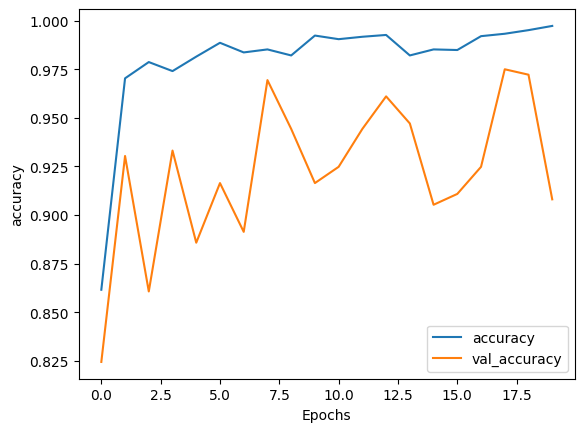

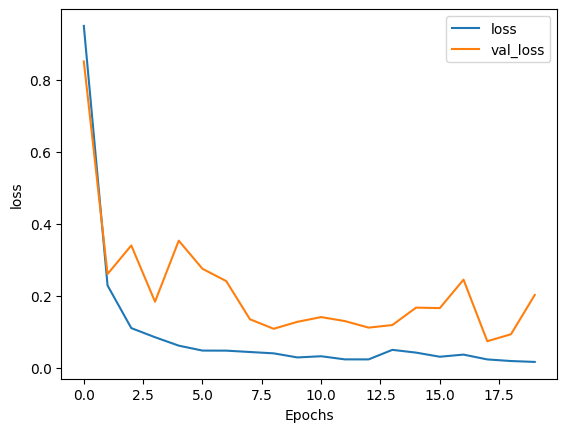

In [96]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [97]:
loaded_model = tf.keras.models.load_model('saved_model.h5')

new_jobs = ["Kami membutuhkan Pengedar Narkoba"]
new_jobs_sequences = vectorize_layer(new_jobs)

predictions = loaded_model.predict(new_jobs_sequences)

threshold = 0.5
for job, prediction in zip(new_jobs, predictions):
    label = "Legal" if prediction[0] >= threshold else "Illegal"
    print(f"Pekerjaan: {job} - Kategori: {label} (Confidence: {prediction[0]:.2f})")

1/1 [==============================] - 2s 2s/step
Pekerjaan: Kami membutuhkan Pengedar Narkoba - Kategori: Illegal (Confidence: 0.00)


In [98]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

y_pred = model.predict(test_dataset)
y_pred = (y_pred > 0.5).astype(int)

y_test_array = tf.concat([y for x, y in test_dataset], axis=0).numpy()

precision = precision_score(y_test_array, y_pred)
recall = recall_score(y_test_array, y_pred)
f1 = f1_score(y_test_array, y_pred)

report = classification_report(y_test_array, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", report)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

12/12 [==============================] - 3s 67ms/step
Classification Report:
               precision    recall  f1-score   support

     illegal       0.41      0.96      0.57        23
       legal       1.00      0.90      0.95       336

    accuracy                           0.91       359
   macro avg       0.70      0.93      0.76       359
weighted avg       0.96      0.91      0.92       359

Precision: 1.00
Recall: 0.90
F1-Score: 0.95


In [ ]:
#import tensorflow as tf
#import tensorflowjs as tfjs
#model.save("sample_data/tf_model/tf_keras.h5")

#tfjs.converters.save_keras_model(model, "sample_data/tfjs_model_keras")

In [99]:
!tensorflowjs_converter --input_format=keras saved_model.h5 sample_data/tfjs_modelnlp2_tf

2024-11-25 03:31:24.449118: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-25 03:31:24.449207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-25 03:31:24.451432: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 03:31:26.176445: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
#model.build(input_shape=(None, 20))  # Pastikan input sudah terdefinisi
#model.save('saved_model_complete.h5')  # Simpan model setelah dibangun

In [ ]:
#!tensorflowjs_converter --input_format=keras --output_format=tfjs_graph_model saved_model_complete.h5 tfjs_model_NLP
#!tensorflowjs_converter --input_format=keras --output_format=tfjs_layers_model saved_model.h5 tfjs_model_NLP



In [ ]:
# Convert the model to TensorFlow.js format
#!tensorflowjs_converter --input_format keras saved_model.h5 tfjs_model6_dir

# Verify the output
#!ls tfjs_model6_dir

In [ ]:
#!zip -r tfjs_model_NLP.zip tfjs_model_NLP
#from google.colab import files
#files.download('tfjs_model_NLP.zip')

In [ ]:
#tensorflowjs_converter --input_format keras model_complete.h5 tfjs_model2_dir


In [ ]:
#model.save("saved_model_dir.keras")  # Menyimpan dengan ekstensi .keras



In [ ]:
#loaded_model = tf.keras.models.load_model("saved_model_dir.keras")
#loaded_model.summary()


In [ ]:
#!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model_dir.keras tfjs_model_NLP
